# Volume Veto
There are essentially 2 main issues I have with many novice recordings.  The first is general shifts in audio level causing a labored listening exerience that can detract from the material being consumed.  This is a constant issue with Udemy courses where the matrial has been updated over the years.  The second is disturbing or harsh audio shifts like bleeps without apropriate leveling or crossfading.

The first issue should be detected by simple level metering, but as the youtube example shows, the disturbing beep is not the loudest moment nor could you reliably trust a shift of 4-6 dB over a 3 second period to detect a sharness shift. (I undersand that the windows do not overlap and as a result lose some capability of this function, but this is a first pass to understand what I am dealing with for signals )

My initial thought for detecting a distrubing shift like this is to look at the FFT and possibly use the harmotic distrobution of the signals as an indicator.

In [1]:
# Does Loudness Measurements
import pyloudnorm as pyln
# Converts Wav file to Numpy array for Pandas/pyloudnorm ()
import soundfile as sf
# Technically dont need this.  Just for listenback...
from pydub.playback import play

In [4]:

main_data, main_rate = sf.read('youtube_snippet.wav')
# Create Meter
meter = pyln.Meter(main_rate)
full_clip_loudness = meter.integrated_loudness(main_data)
print("Rate = ",main_rate, "Length = ", len(main_data), "Full Clip Avg Loudness = ", full_clip_loudness)

Rate =  44100 Length =  930304 Full Clip Avg Loudness =  -27.441594290567892


In [5]:
count = 0
one_second_ave_loudness = []
# There should be overlap when going point to point, but for first pass inspection, I am just doing full window jumps. 
for i in range(int(len(main_data)/main_rate)):
    count+=1
    one_second_loudness = meter.integrated_loudness(main_data[i*main_rate:(i+1)*main_rate])
    one_second_ave_loudness.append(one_second_loudness)

In [6]:
one_second_ave_loudness

[-28.630723575139186,
 -26.348079151990074,
 -24.154765209954288,
 -29.373650045496507,
 -29.389179461888844,
 -28.37314608158987,
 -28.902043645053027,
 -29.246138099433413,
 -33.18063990480254,
 -24.676530867368164,
 -28.50905768323213,
 -28.90114098345691,
 -25.74422517354052,
 -27.310941947516522,
 -25.773400351226496,
 -28.860361351640027,
 -24.890363321127193,
 -28.57750593295912,
 -26.98510186931553,
 -28.60770213148224,
 -29.04774255245142]

## Power Problem
16 seconds into this sample there is a 1k bleep that is a little bit uncomfortable.  You can't really tell from the single power level though.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import rfft, fft, ifft

In [ ]:
i = 16

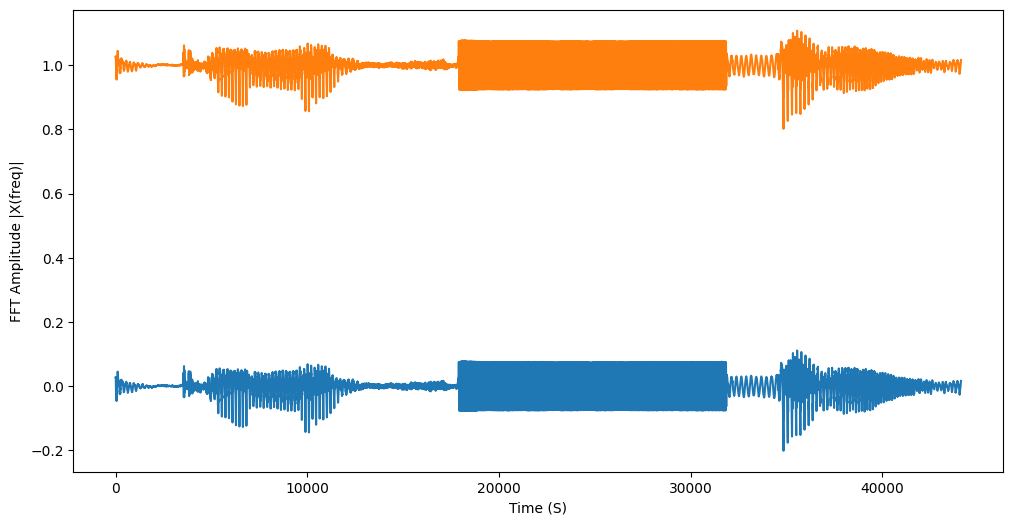

In [79]:
plt.figure(figsize = (12, 6))

left_sig = []
right_sig = []
for j in main_data[i*main_rate:(i+1)*main_rate]:
    left_sig.append(j[0])
    # I am just adding 1 here to be able to see it. I will be processing the Left singnal from here on out.
    right_sig.append(j[1]+1)
plt.plot(left_sig)
plt.plot(right_sig)
plt.xlabel('Time (S)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

[-1.66418457+0.j         -1.50163253-0.95198777j -0.11816457-1.16411605j
 ...  0.00611911-0.17503235j -0.11816457+1.16411605j
 -1.50163253+0.95198777j]
44100 44100 44100 1.0


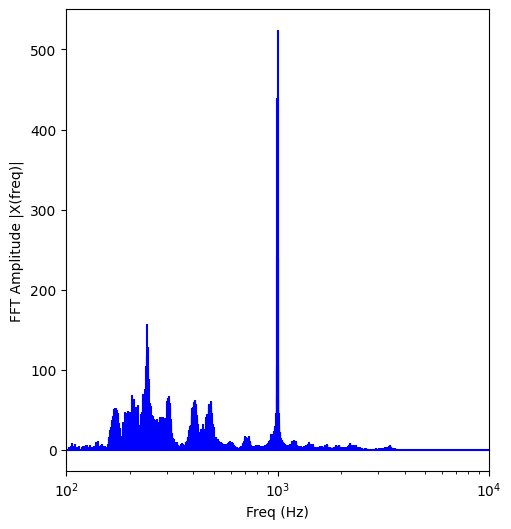

In [155]:
i = 16
# You need to split the Stereo signal to get the FFT to work properly
left_sig = []
right_sig = []
for j in main_data[i*main_rate:(i+1)*main_rate]:
    left_sig.append(j[0])
    right_sig.append(j[1]+1)
X_left = fft(left_sig)

N = len(X_left)
n = np.arange(N)
T = N/main_rate
freq = n/T
print(X_left)

print(len(np.abs(X_left)), len(freq), len(n), T)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X_left), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xscale("log")
plt.xlim(100,10000)
# plt.xtick
plt.show()

Look at all that power at 1k!!!  Below you will see the FFT for the second prior.  (Ill set up a better x scale later)

In [127]:
abs_fft = np.abs(X_left).tolist()
max_num = max(abs_fft)
abs_fft.index(max_num)

1000

[-1.89837646+0.j         -1.87520323-0.18501952j -2.07993963+0.25336129j
 ... -2.0494361 -0.11576355j -2.07993963-0.25336129j
 -1.87520323+0.18501952j]
44100 44100 44100 1.0


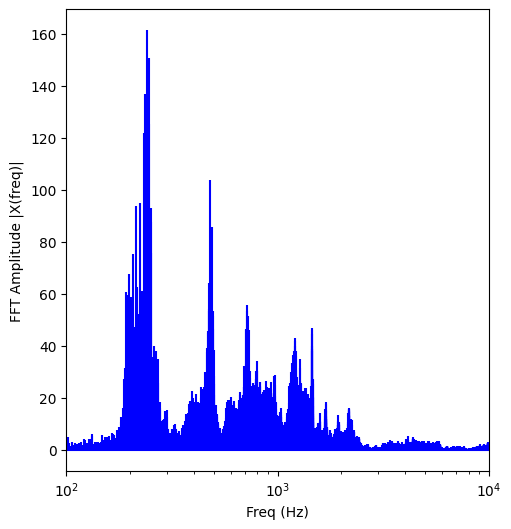

In [152]:
i=15
# You need to split the Stereo signal to get the FFT to work properly
left_sig = []
right_sig = []
for j in main_data[i*main_rate:(i+1)*main_rate]:
    left_sig.append(j[0])
    right_sig.append(j[1]+1)
X_left = fft(left_sig)

N = len(X_left)
n = np.arange(N)
T = N/main_rate
freq = n/T
print(X_left)

print(len(np.abs(X_left)), len(freq), len(n), T)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X_left), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xscale("log")
plt.xlim(100,10000)
# plt.xtick
plt.show()

Look at that harmonic distribution of a male voice talking!

## Possible Solution:
Reconstruct the loudness using parcial frequncy bands and detect if there is a time that a disproportionately large ammount of the power if coming from one area?

Compare peak values from period to period? The beep had 500 while the next loudest thing I saw was around 250 from a boomy mic proximity moment.